In [7]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader,RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.optim as optim
import random

Functions

In [20]:
def show_random_headlines(total_number, df):
    n_reviews = df.sample(total_number)
    for val in list(n_reviews.index):
        print("News #{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["Sentiment"]))
        print(" - Headline: {}".format(df.iloc[val]["Title"]))
        print("")
        

def show_headline_distribution(sequence_lengths, figsize=(15, 8)):
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus) / len(sequence_lengths)) * 100
    print("Max sequence length {}".format(max(sequence_lengths)))
    plt.figure(figsize=figsize)
    sns.set(style='darkgrid')
    sns.set(font_scale=1.3)
    sns.displot(sequence_lengths, kde=False, rug=False)
    plt.title('Distribution of lengths of headlines')
    plt.xlabel('Length')
    plt.ylabel('Number')
    plt.show()


def show_random_headlines(total_number, df):
    n_reviews = df.sample(total_number)
    for val in list(n_reviews.index):
        print("News #{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["Sentiment"]))
        print(" - Headlines: {}".format(df.iloc[val]["Title"]))
        print("")


def get_headlines_len(df):
    headlines_sequence_lengths = []
    for headline in tqdm(df.Title):
        encoded_headline = finbert_tokenizer.encode(headline, add_special_tokens=True)
        headlines_sequence_lengths.append(len(encoded_headline))
    print("Done")
 
    return headlines_sequence_lengths


def encode_sentiments_values(df):
    possible_sentiments = df.Sentiment.unique()
    sentiment_dict = {}   
    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index  
    df['label'] = df.Sentiment.replace(sentiment_dict)   
    return df, sentiment_dict

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
 
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    pred_nb = 0
    true_nb = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Label: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        pred_nb += len(y_preds[y_preds==label])
        true_nb += len(y_true)
    print('accuracy: ', pred_nb/true_nb)


def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)           
 
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)    

    loss_val_avg = loss_val_total/len(dataloader_val)    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [9]:
# preprocessing
df_pre = pd.read_csv('sentiment_gpt4_only.csv')
replacements = {'- positive': 'positive', '- negative': 'negative', '- indecisive': 'indecisive'}
df = df_pre.replace(replacements)

In [10]:
# encode sentiments
df_encoded, sentiment_dict = encode_sentiments_values(df)
sentiment_dict

{'positive': 0, 'negative': 1, 'indecisive': 2}

In [11]:
# generate train dataset and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(df_encoded.index.values,
                                                  df_encoded.label.values,
                                                  test_size = 0.15,
                                                  random_state = 2022,
                                                  stratify = df_encoded.label.values)
# X_train is a list of the index of elements for training
# Y_train is a list of the labels of elements for training

#verify if the distribution of train dataset and test dataser is reasonable
df_encoded['data_type'] = pd.Series(dtype='object')
df_encoded.loc[X_train, 'data_type'] = 'train'
df_encoded.loc[X_test, 'data_type'] = 'test'
df_encoded.groupby(['Sentiment', 'label', 'data_type']).count()

Date  Title
Sentiment  label data_type             
indecisive 2     test         98     98
                 train       553    553
negative   1     test        612    612
                 train      3468   3468
positive   0     test        511    511
                 train      2897   2897

In [12]:
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert",  do_lower_case=True)

100%|██████████| 8139/8139 [00:01<00:00, 4377.81it/s]


Done
Max sequence length 38


<Figure size 1500x800 with 0 Axes>

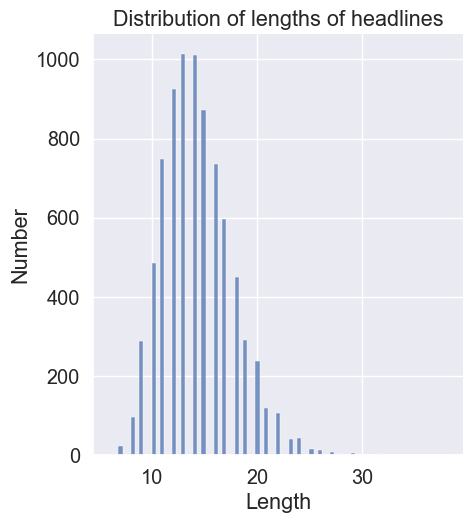

In [13]:
headlines_sequence_lengths = get_headlines_len(df_encoded)
show_headline_distribution(headlines_sequence_lengths)

In [14]:
# Preparation for model train
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    df_encoded[df_encoded.data_type=='train'].Title.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=38, 
    truncation=True 
)

encoded_data_test = finbert_tokenizer.batch_encode_plus(
    df_encoded[df_encoded.data_type=='test'].Title.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=38, 
    truncation=True 
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_encoded[df_encoded.data_type=='train'].label.values)
 
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
sentiments_test = torch.tensor(df_encoded[df_encoded.data_type=='test'].label.values)
 
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, sentiments_test)
 
len(sentiment_dict)

3

In [15]:
# Loading pre-training model
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
 
                                                          num_labels=len(sentiment_dict),
 
                                                          output_attentions=False,
 
                                                          output_hidden_states=False)


In [16]:
# Dataloader
batch_size = 5
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
 
dataloader_validation = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=batch_size)

In [17]:
# Set up the optimizer and the learning rate scheduler, and specify the total number of training epochs
epochs = 2
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [28]:
# Training
seed_test = 2022
random.seed(seed_test)
np.random.seed(seed_test)
torch.manual_seed(seed_test)
torch.cuda.manual_seed_all(seed_test)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
 
for epoch in tqdm(range(1, epochs+1)): 
    model.train()  
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()    
        batch = tuple(b.to(device) for b in batch)     
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
 
        outputs = model(**inputs)  
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()     
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})          
    torch.save(model.state_dict(), f'finetuned_finBERT_epoch_{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|                                                     | 0/2 [27:58<?, ?it/s]


Epoch 1
Training loss: 0.478417780343174


 50%|█████████████████████▌                     | 1/2 [28:43<28:43, 1723.32s/it]

Validation loss: 0.4112782022830251
F1 Score (Weighted): 0.8843301633354589



 50%|█████████████████████▌                     | 1/2 [56:57<28:43, 1723.32s/it]


Epoch 2
Training loss: 0.2801739092586687


100%|███████████████████████████████████████████| 2/2 [57:52<00:00, 1736.16s/it]

Validation loss: 0.47523442352884354
F1 Score (Weighted): 0.8851760033703517


In this scenario, we observe a decrease in the training loss from the first to the second epoch, suggesting that the model continues to learn from the training data. However, there is a slight increase in the validation loss between the first and second epochs. This discrepancy between the training and validation losses indicates that the model may be overfitting to the training data, as it performs well on the training data but fails to generalize effectively to the validation data.

Therefore, based on the trends in the losses, it appears that the model may be experiencing overfitting after the second epoch. To address overfitting, strategies such as early stopping or regularization techniques can be applied.

In [21]:
# stop at epoch 1
sentiment_dict = {'positive': 0, 'negative': 1, 'indecisive': 2}
sentiment_dict_inverse = dict(zip(sentiment_dict.values(), sentiment_dict.keys()))

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load('./finetuned_finBERT_epoch_1.model', map_location=torch.device('cpu')))
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)


Label: positive
Accuracy: 466/511

Label: negative
Accuracy: 566/612

Label: indecisive
Accuracy: 52/98

accuracy:  0.8877968877968878


Predict sentiments of the new titles

100%|██████████| 587/587 [00:00<00:00, 2814.45it/s]


Done
Max sequence length 41


<Figure size 1500x800 with 0 Axes>

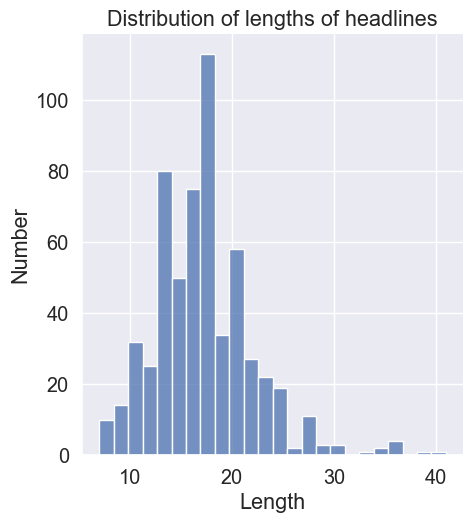

In [22]:
new_title_df = pd.read_csv('new_titles.csv')

headlines_sequence_lengths_pred = get_headlines_len(new_title_df)
show_headline_distribution(headlines_sequence_lengths_pred)

In [23]:
model.eval()

encoded_data_pred = finbert_tokenizer.batch_encode_plus(
    new_title_df.Title.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=41, 
    truncation=True 
)


input_ids_pred = encoded_data_pred['input_ids']
attention_masks_pred = encoded_data_pred['attention_mask']
dataset_pred = TensorDataset(input_ids_pred, attention_masks_pred)

with torch.no_grad():
    inputs = {
        'input_ids': encoded_data_pred['input_ids'].to(device),
        'attention_mask': encoded_data_pred['attention_mask'].to(device)
    }
    outputs = model(**inputs)

logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
sentiment_dict_inverse = dict(zip(sentiment_dict.values(), sentiment_dict.keys()))
for title, label_id in zip(new_title_df.Title.values, predicted_labels):
    sentiment = sentiment_dict_inverse[label_id]
    new_title_df['Sentiment'] = new_title_df['Sentiment'].astype(str)
    new_title_df.loc[new_title_df['Title'] == title, 'Sentiment'] = sentiment

In [25]:
new_title_df.head()

,Date,Title,Sentiment
0,2010-01-04 08:00:00+00:00,Wall St. Extends '09 Rally into New Year - CBS...,positive
1,2010-01-05 08:00:00+00:00,Warren Buffett weighs into Kraft's battle for ...,indecisive
2,2010-01-07 08:00:00+00:00,Fear of the dragon - The Economist,indecisive
3,2010-01-10 08:00:00+00:00,Fundamental Opportunities in Emerging Markets ...,positive
4,2010-01-11 08:00:00+00:00,How News Happens - Pew Research Center,indecisive


In [26]:
new_title_df.to_excel('SA_Finber_for_new_titles.xlsx', index=False)